# Supply trend with market rates
This is an example combining functionality from our *Voyages*, *Market Rates* and *Tonnage List* APIs. The aim of the example is to plot a supply trend with superimposed, predicted market rates, in order to get a hollistic view of market behaviour during a specific period, for a specific load port, and a specific vessel class.

## Run this example in [Colab](https://colab.research.google.com/github/SignalOceanSdk/SignalSDK/blob/master/docs/examples/jupyter/Combined%20Examples/Supply%20trend%20with%20market%20rates.ipynb) 

## Setup
Install the Signal Ocean SDK:

In [ ]:
!pip install signal-ocean

Import required dependencies:

In [2]:
from datetime import date, timedelta

import pandas as pd
import matplotlib.pyplot as plt

from signal_ocean import Connection
from signal_ocean.voyages import VoyagesAPI
from signal_ocean.market_rates import MarketRatesAPI
from signal_ocean.tonnage_list import (
    TonnageListAPI,
    VesselClassFilter,
    PortFilter,
    VesselFilter,
    PushType,
    MarketDeployment,
    CommercialStatus,
    VesselSubclass,
    IndexLevel,
    DateRange,
)


Get your personal Signal Ocean API subscription key (acquired [here](https://apis.signalocean.com/profile)) and use it to create a `Connection`:

In [3]:
signal_ocean_api_key = ""  # replace with your subscription key
connection = Connection(signal_ocean_api_key)


Create instances of APIs used throughout this notebook:

In [4]:
voyage_api = VoyagesAPI(connection)
tonnage_list_api = TonnageListAPI(connection)
market_rate_api = MarketRatesAPI(connection)

## Parametrization

In order to plot a supply trend with the predicted market rates, we need to specify the following parameters for our queries:
1. `vessel_class` - the class of queried vessels.
1. `load_port` - the loading port.
1. `days_back` - the number of days the supply trend should reach back, starting from the current date.
1. `laycan_end_in_days` - the maximum estimated time of arrival for available vessels to reach the loading port.
1. `push_type` - the vessels' push status, if available from the emails in your account.
1. `market_deployment` - the vessels' market deployment. 
1. `commercial_status` - commercial status of the vessels at each point in time.
1. `vessel_subclass` - the type of oil product the vessel is classified to carry.
1. `ais_since` - how many days since the vessel has transmitted its AIS data.
1. `route_description` - the route of interest with available market rates.

In [5]:
vessel_class_filter = VesselClassFilter(name_like="Aframax")
load_port_filter = PortFilter(name_like="Ceyhan")
days_back = 90
laycan_end_in_days = 10

vessel_filter = VesselFilter(
    push_types=[PushType.PUSHED_POSS, PushType.PUSHED],
    market_deployments=[MarketDeployment.RELET, MarketDeployment.SPOT],
    commercial_statuses=[
        CommercialStatus.AVAILABLE,
        CommercialStatus.ON_SUBS,
        CommercialStatus.FAILED,
        CommercialStatus.CANCELLED,
    ],
    vessel_subclass=VesselSubclass.DIRTY,
    latest_ais_since=5,
)

route_description = "Afra - BSea/Med"

today = date.today()
start_date = today - timedelta(days=days_back)
end_date = today


For more information, see the [Tonnage List](../../../../tonnage_list) and  [Market Rate](../../../../market_rates) API sections.

## Retrieve the historical tonnage list

In [6]:
vessel_class = tonnage_list_api.get_vessel_classes(vessel_class_filter)[0]
load_port = tonnage_list_api.get_ports(load_port_filter)[0]

htl = tonnage_list_api.get_historical_tonnage_list(
    load_port,
    vessel_class,
    laycan_end_in_days,
    DateRange(start_date, end_date),
    vessel_filter,
)

htl_for_supply_trend = htl.to_data_frame()
htl_for_supply_trend


name vessel_class ice_class  \
date                      imo                                             
2021-10-13 12:00:00+00:00 9388807       Seajewel      Aframax       NaN   
                          9334727      Dugi Otok      Aframax        1C   
                          9796743           Rava      Aframax        1C   
                          9395331       Corossol      Aframax       NaN   
                          9776767         Tigani      Aframax        1A   
...                                          ...          ...       ...   
2021-07-16 12:00:00+00:00 9514169  Green Warrior      Aframax       NaN   
                          9297321  Minerva Ellie      Aframax        1A   
                          9577044    Catalan Sea      Aframax       NaN   
                          9285861   Minerva Iris      Aframax        1A   
                          9765029      Searunner      Aframax        1C   

                                   year_built  deadweight  length_overall  \
date                      imo                                               
2021-10-13 12:00:00+00:00 9388807        2009      108929          245.07   
                          9334727        2008      108414          247.24   
                          9796743        2017      114385          250.00   
                          9395331        2010      106898          243.80   
                          9776767        2017      113000          249.89   
...                                       ...         ...             ...   
2021-07-16 12:00:00+00:00 9514169        2011      104626          228.60   
                          9297321        2005      103194          244.00   
                          9577044        2012      116619          249.90   
                          9285861        2004      103124          243.57   
                          9765029        2017      114129          250.00   

                                   breadth_extreme subclass  \
date                      imo                                 
2021-10-13 12:00:00+00:00 9388807               42    Dirty   
                          9334727               48    Dirty   
                          9796743               44    Dirty   
                          9395331               42    Dirty   
                          9776767               44    Dirty   
...                                            ...      ...   
2021-07-16 12:00:00+00:00 9514169               42    Dirty   
                          9297321               42    Dirty   
                          9577044               44    Dirty   
                          9285861               42    Dirty   
                          9765029               44    Dirty   

                                  market_deployment_point_in_time  \
date                      imo                                       
2021-10-13 12:00:00+00:00 9388807                            Spot   
                          9334727                            Spot   
                          9796743                            Spot   
                          9395331                            Spot   
                          9776767                            Spot   
...                                                           ...   
2021-07-16 12:00:00+00:00 9514169                            Spot   
                          9297321                            Spot   
                          9577044                            Spot   
                          9285861                            Spot   
                          9765029                            Spot   

                                  push_type_point_in_time  ...  \
date                      imo                              ...   
2021-10-13 12:00:00+00:00 9388807                  Pushed  ...   
                          9334727                  Pushed  ...   
                          9796743                  Pushed  ...   
                  

## Get daily market rates for the route
We'll need a helper function to find our desired route for the market rates:

In [7]:
def return_selected_route(vessel_class, route_description):
    vessel_routes = market_rate_api.get_routes(vessel_class_id=vessel_class.id)
    for i, v in enumerate(vessel_routes):
        if vessel_routes[i].description == route_description:
            break
    return vessel_routes[i]


Which we can use to find the route object returned from the Market Rates API:

In [8]:
market_rate_route = return_selected_route(vessel_class, route_description)


And use it to query for market rates:

In [9]:
market_rates = market_rate_api.get_market_rates(
    start_date,
    route_id=market_rate_route.id,
    vessel_class_id=vessel_class.id,
    end_date=end_date,
    is_clean=market_rate_route.is_clean
)

market_rates = pd.DataFrame([vars(vr) for vr in market_rates])
market_rates["rate_date"] = pd.to_datetime(market_rates["rate_date"])
market_rates.set_index("rate_date", inplace=True)
market_rates


,route_id,rate_value,unit,vessel_class_id
rate_date,,,,
2021-07-16,R1,91.25,WS,86
2021-07-17,R1,91.25,WS,86
2021-07-18,R1,91.25,WS,86
2021-07-19,R1,91.25,WS,86
2021-07-20,R1,93.75,WS,86
...,...,...,...,...
2021-10-10,R1,110.00,WS,86
2021-10-11,R1,107.50,WS,86
2021-10-12,R1,105.00,WS,86


## Plot the daily supply trend with market rates

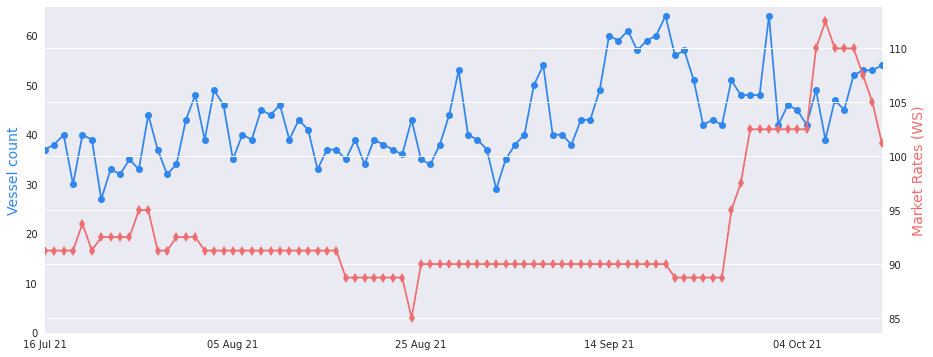

In [10]:
plt.style.use("seaborn")
fig, axs = plt.subplots(figsize=(15, 6))

supply_trend = htl_for_supply_trend.groupby(IndexLevel.DATE, sort=True).size()
supply_trend.index = supply_trend.index.strftime("%d %b %y")

# Left axis (Supply plot)
supply_plot = supply_trend.plot(ax=axs, x="date", color="#3086EF", marker="o")
supply_plot.set_ylabel(
    "Vessel count", color=plt.gca().lines[-1].get_color(), fontsize=14
)
supply_plot.set_ylim(ymin=0)

# Right axis (Market rate plot)
market_rates.index = market_rates.index.strftime("%d %b %y")
mr_plot = market_rates.plot(
    ax=axs, y="rate_value", secondary_y=True, color="#F06C6E", marker="d"
)
mr_plot.set_ylabel(
    "Market Rates (WS)", color=plt.gca().lines[-1].get_color(), fontsize=14
)

axs.set_xlim(0, len(supply_trend) - 1)
axs.set_xlabel("")
axs.get_legend().remove()


## Perform a point-to-point comparison

Here's an example of a workflow to compare two different points in time.

Specify the dates to compare:

In [11]:
point_a = today - timedelta(days=1)
point_b = today - timedelta(days=5)


In [12]:
dates = htl_for_supply_trend.index.get_level_values("date").date

if not any(dates == point_a):
    raise ValueError("Point A is not within imported date values.")
elif not any(dates == point_b):
    raise ValueError("Point B is not within imported date values.")

vessels_in_a = htl_for_supply_trend.loc[(dates == point_a)]
vessels_in_b = htl_for_supply_trend.loc[(dates == point_b)]


### Intersection of Vessel IMOs

In [13]:
intersection = pd.merge(
    vessels_in_a.add_suffix("_IN_A"),
    vessels_in_b.add_suffix("_IN_B"),
    how="inner",
    on="imo",
)

intersection


,name_IN_A,vessel_class_IN_A,ice_class_IN_A,year_built_IN_A,deadweight_IN_A,length_overall_IN_A,breadth_extreme_IN_A,subclass_IN_A,market_deployment_point_in_time_IN_A,push_type_point_in_time_IN_A,...,commercial_operator_point_in_time_IN_B,commercial_status_point_in_time_IN_B,eta_point_in_time_IN_B,latest_ais_point_in_time_IN_B,open_prediction_accuracy_point_in_time_IN_B,open_country_point_in_time_IN_B,open_narrow_area_point_in_time_IN_B,open_wide_area_point_in_time_IN_B,availability_port_type_point_in_time_IN_B,availability_date_type_point_in_time_IN_B
imo,,,,,,,,,,,,,,,,,,,,,
9388807,Seajewel,Aframax,NaN,2009,108929,245.07,42,Dirty,Spot,Pushed,...,Thenamaris,Available,2021-10-11 02:00:00+00:00,2021-10-06 13:15:04+00:00,Narrow Area,Israel,East Mediterranean,Mediterranean,Source,Source
9796743,Rava,Aframax,1C,2017,114385,250.00,44,Dirty,Spot,Pushed,...,Tankerska Plovidba dd,Available,2021-10-14 13:00:00+00:00,2021-10-09 08:17:37+00:00,Port,Italy,Central Mediterranean,Mediterranean,Source,Prediction
9395331,Corossol,Aframax,NaN,2010,106898,243.80,42,Dirty,Spot,Pushed,...,Cardiff Marine,Available,2021-10-11 14:00:00+00:00,2021-10-09 08:17:00+00:00,Narrow Area,Greece,East Mediterranean,Mediterranean,Source,Source
9776767,Tigani,Aframax,1A,2017,113000,249.89,44,Dirty,Spot,Pushed POSS,...,Cardiff Marine,Available,2021-10-12 10:00:00+00:00,2021-10-09 07:19:16+00:00,Narrow Area,Italy,Central Mediterranean,Mediterranean,Source,Source
9345441,Aegean Nobility,Aframax,NaN,2007,115814,248.94,44,Dirty,Spot,Pushed,...,Arcadia Shipmanagement,Available,2021-10-12 12:00:00+00:00,2021-10-09 08:13:42+00:00,Narrow Area,Italy,Central Mediterranean,Mediterranean,Source,Source
9389966,Alexia,Aframax,NaN,2009,107574,243.80,42,Dirty,Spot,Pushed,...,Centrofin,Available,2021-10-13 20:00:00+00:00,2021-10-09 08:17:27+00:00,Narrow Area,Israel,East Mediterranean,Mediterranean,Source,Prediction
9321677,Kronviken,Aframax,1A,2006,109999,248.99,44,Dirty,Relet,Pushed,...,Vitol,Available,2021-10-15 01:00:00+00:00,2021-10-09 08:14:34+00:00,Port,Turkey,Sea of Marmara,Black Sea / Sea Of Marmara,Source,Prediction
9521435,Nordrose,Aframax,NaN,2012,104583,228.60,42,Dirty,Spot,Pushed,...,N2 Tankers,Available,2021-10-15 21:00:00+00:00,2021-10-09 08:17:14+00:00,Port,Italy,Central Mediterranean,Mediterranean,Source,Source
9337418,Patmos Warrior,Aframax,NaN,2007,105572,239.00,42,Dirty,Spot,Pushed,...,Polembros Shipping,Available,2021-10-16 13:00:00+00:00,2021-10-09 08:17:56+00:00,Port,Italy,Central Mediterranean,Mediterranean,Source,Source


### Difference between vessel IMOs in relation to point A

In [14]:
vessels_in_a_but_not_in_b = (
    vessels_in_a.add_suffix("_IN_A")
    .merge(
        vessels_in_b.add_suffix("_IN_B"), indicator=True, how="left", on="imo"
    )
    .loc[lambda x: x["_merge"] != "both"]
)

vessels_in_a_but_not_in_b


,name_IN_A,vessel_class_IN_A,ice_class_IN_A,year_built_IN_A,deadweight_IN_A,length_overall_IN_A,breadth_extreme_IN_A,subclass_IN_A,market_deployment_point_in_time_IN_A,push_type_point_in_time_IN_A,...,commercial_status_point_in_time_IN_B,eta_point_in_time_IN_B,latest_ais_point_in_time_IN_B,open_prediction_accuracy_point_in_time_IN_B,open_country_point_in_time_IN_B,open_narrow_area_point_in_time_IN_B,open_wide_area_point_in_time_IN_B,availability_port_type_point_in_time_IN_B,availability_date_type_point_in_time_IN_B,_merge
imo,,,,,,,,,,,,,,,,,,,,,
9334727,Dugi Otok,Aframax,1C,2008,108414,247.24,48,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9255684,Minerva Zoe,Aframax,1D,2004,105330,243.96,42,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9724336,Leontios H,Aframax,NaN,2016,113611,249.97,44,Dirty,Relet,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9426441,Ionic Artemis,Aframax,NaN,2009,107605,243.80,40,Dirty,Relet,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9282792,Atalandi,Aframax,NaN,2004,105306,248.00,43,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9527855,Alicante,Aframax,NaN,2013,115707,248.97,44,Dirty,Spot,Pushed POSS,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9880350,Searhythm,Aframax,NaN,2021,111650,237.00,44,Dirty,Relet,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9370850,Syros Warrior,Aframax,NaN,2009,107687,243.80,42,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9346885,Mare Nostrum,Aframax,NaN,2009,110295,245.50,42,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only


### Difference between vessel IMOs in relation to point B

In [15]:
vessels_in_b_but_not_in_a = (
    vessels_in_b.add_suffix("_IN_B")
    .merge(
        vessels_in_a.add_suffix("_IN_A"), indicator=True, how="left", on="imo"
    )
    .loc[lambda x: x["_merge"] != "both"]
)

vessels_in_b_but_not_in_a


,name_IN_B,vessel_class_IN_B,ice_class_IN_B,year_built_IN_B,deadweight_IN_B,length_overall_IN_B,breadth_extreme_IN_B,subclass_IN_B,market_deployment_point_in_time_IN_B,push_type_point_in_time_IN_B,...,commercial_status_point_in_time_IN_A,eta_point_in_time_IN_A,latest_ais_point_in_time_IN_A,open_prediction_accuracy_point_in_time_IN_A,open_country_point_in_time_IN_A,open_narrow_area_point_in_time_IN_A,open_wide_area_point_in_time_IN_A,availability_port_type_point_in_time_IN_A,availability_date_type_point_in_time_IN_A,_merge
imo,,,,,,,,,,,,,,,,,,,,,
9408310,Sea Voyager,Aframax,NaN,2009,107506,243.80,42,Dirty,Relet,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9379624,Fos Picasso,Aframax,NaN,2009,115760,248.96,44,Dirty,Relet,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9592276,Stamos,Aframax,NaN,2012,115666,240.63,44,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9247390,Neverland,Aframax,NaN,2003,105411,239.00,42,Dirty,Relet,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9417323,Whistler Spirit,Aframax,NaN,2010,109011,243.00,42,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9343340,Gemini Sun,Aframax,NaN,2008,115577,243.80,42,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9528043,Daytona,Aframax,NaN,2011,115896,248.97,44,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9592288,Indigo Sun,Aframax,NaN,2012,115724,248.97,44,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9897834,Carina Voyager,Aframax,NaN,2021,115000,249.90,44,Dirty,Relet,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
